In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
path = 'data/healthcare-dataset-stroke-data.csv'

dataframe = pd.read_csv(path)
dataframe.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
bins = [0, 2, 18, 40, 60, 82]
labels = ['newborn', 'child', 'young adult', 'middle age', 'senior']

dataframe['age_group'] = pd.cut(dataframe['age'],bins = bins,labels = labels,right=True)

In [5]:
bmi_mean_by_age = dataframe.groupby('age_group')['bmi'].mean().to_dict()

/var/folders/28/pmh07v693dn2c3l0jdz5zvlw0000gn/T/ipykernel_35321/474049611.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bmi_mean_by_age = dataframe.groupby('age_group')['bmi'].mean().to_dict()


In [6]:
for key,val in bmi_mean_by_age.items():
    mask = (dataframe['age_group'] == key) & (dataframe['bmi'].isna())
    dataframe.loc[mask,'bmi'] = val
    
dataframe['bmi'] = dataframe['bmi'].round(2)

#discretization and smoothing for bmi
# Define bin edges from 10 to 100 with a step of 10
bin_edges_bmi = np.arange(10, 100 + 5, 5)  # [10, 20, 30, ..., 100]

# Create BMI bins
dataframe['bmi_bin'] = pd.cut(dataframe['bmi'], bins=bin_edges_bmi, include_lowest=True)

# Replace BMI values with bin means
dataframe['bmi'] = dataframe.groupby('bmi_bin')['bmi'].transform('mean')


/var/folders/28/pmh07v693dn2c3l0jdz5zvlw0000gn/T/ipykernel_35321/959797956.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataframe['bmi'] = dataframe.groupby('bmi_bin')['bmi'].transform('mean')


In [7]:
dataframe = dataframe.drop(['age_group','bmi_bin','id'],axis=1)
dataframe

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,37.245200,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,27.747544,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.295168,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,32.295168,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,22.759631,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,27.747544,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,37.245200,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,32.295168,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,27.747544,formerly smoked,0


In [31]:
# Converting 'smoking_status' to binary: smoker = 1, else = 0
#dataframe['smokes'] = (dataframe['smoking_status'] == 'smokes').astype(int)
#dataframe['never smoked'] = (dataframe['smoking_status'] == 'never smoked').astype(int)
#dataframe['formerly smoked'] = (dataframe['smoking_status'] == 'formerly smoked').astype(int)

In [32]:
#dataframe = dataframe.drop('smoking_status',axis=1)
#dataframe

Let’s examine whether some of the features provide meaningful information. For example, we can analyze the impact of residence type on the likelihood of stroke. Additionally, the 'work type' feature may be informative, as occupational stress could potentially contribute to an increased risk of stroke.

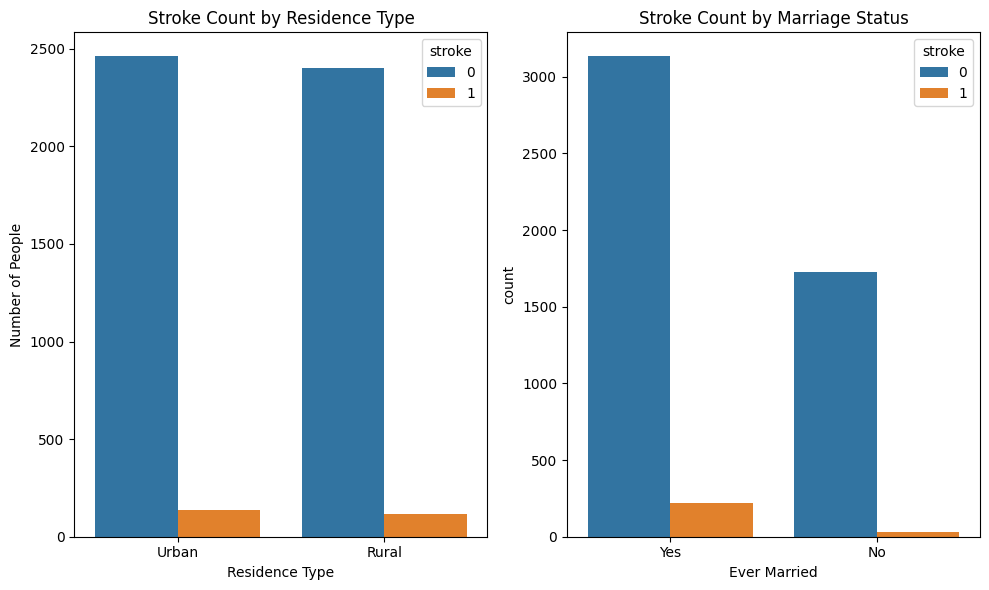

In [8]:
fig, axes = plt.subplots(1,2,figsize=(10,6))
sns.countplot(data=dataframe, x='Residence_type', hue='stroke',ax = axes[0])
axes[0].set_title('Stroke Count by Residence Type')

axes[0].set_xlabel('Residence Type')
axes[0].set_ylabel('Number of People')

sns.countplot(data=dataframe,x = 'ever_married',hue='stroke',ax=axes[1])
axes[1].set_title('Stroke Count by Marriage Status')
axes[1].set_xlabel('Ever Married')

plt.tight_layout()
plt.show()

We observe that the number of people who had a stroke and live in an urban environment is only slightly higher than those in rural areas. Since the difference is minimal, I will consider removing this feature from the dataset, as it may not contribute significantly to the model.
But in case of marriage there is  noticeable difference, so i will use this feature.

In [9]:
dataframe = dataframe.drop(axis=1,columns='Residence_type')

Let's take a look on on worktype and anount of stroke .


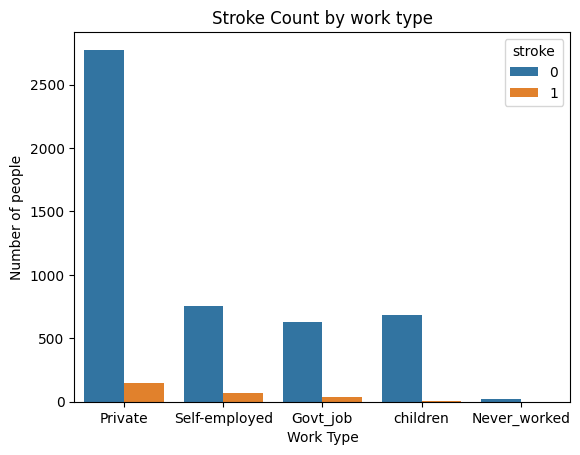

In [10]:
sns.countplot(data=dataframe, x='work_type', hue='stroke')
plt.title("Stroke Count by work type")
plt.xlabel('Work Type')
plt.ylabel('Number of people')

plt.show()

We can notice that the number of stroke cases in the private sector neither then in other type of work type. So this feature could be useful.

In [11]:
from scipy.stats import norm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
#Encode categorical values
from sklearn.preprocessing import OrdinalEncoder
categorical_columns = dataframe.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_columns

['gender', 'ever_married', 'work_type', 'smoking_status']

In [13]:
encoder =OrdinalEncoder()

dataframe_cp = dataframe.copy()
dataframe_cp[categorical_columns] = encoder.fit_transform(dataframe[categorical_columns])

In [14]:
dataframe_cp = dataframe_cp.round(2)
dataframe_cp

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke
0,1.0,67.0,0,1,1.0,2.0,228.69,37.25,1.0,1
1,0.0,61.0,0,0,1.0,3.0,202.21,27.75,2.0,1
2,1.0,80.0,0,1,1.0,2.0,105.92,32.30,2.0,1
3,0.0,49.0,0,0,1.0,2.0,171.23,32.30,3.0,1
4,0.0,79.0,1,0,1.0,3.0,174.12,22.76,2.0,1
...,...,...,...,...,...,...,...,...,...,...
5105,0.0,80.0,1,0,1.0,2.0,83.75,27.75,2.0,0
5106,0.0,81.0,0,0,1.0,3.0,125.20,37.25,2.0,0
5107,0.0,35.0,0,0,1.0,3.0,82.99,32.30,2.0,0
5108,1.0,51.0,0,0,1.0,2.0,166.29,27.75,1.0,0


In [ ]:
# Separate features and labels
X = dataframe_cp.drop('stroke', axis=1)
y = dataframe_cp['stroke']

# Split before SMOTE to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
print((y_train==1).sum())

160


In [46]:
y_test

4688    0
4478    0
3849    0
4355    0
3826    0
       ..
818     0
4829    0
611     0
3082    0
3407    0
Name: stroke, Length: 1533, dtype: int64

In [47]:
X_test

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status
4688,1.0,31.0,0,0,0.0,3.0,64.85,22.76,0.0
4478,1.0,40.0,0,0,1.0,3.0,65.29,27.75,2.0
3849,0.0,8.0,0,0,0.0,4.0,74.42,22.76,0.0
4355,0.0,79.0,1,0,1.0,3.0,76.64,17.95,2.0
3826,0.0,75.0,0,0,1.0,0.0,94.77,27.75,2.0
...,...,...,...,...,...,...,...,...,...
818,1.0,20.0,0,0,0.0,0.0,106.97,27.75,1.0
4829,1.0,66.0,0,0,1.0,2.0,67.92,32.30,1.0
611,1.0,42.0,0,0,1.0,0.0,93.79,27.75,2.0
3082,0.0,57.0,0,0,1.0,2.0,69.40,22.76,0.0


### SMOTE algorithm for the imbalanced data

In [40]:
smote = SMOTE(random_state=42,sampling_strategy=0.1)
X_res_train, y_res_train = smote.fit_resample(X_train, y_train)


In [41]:
print((y_res_train==1).sum())

341


In [17]:
scale_columns = ['age','avg_glucose_level','bmi']
# Transformer for numeric columns only
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), scale_columns)
    ],
    remainder='passthrough'  # keep other columns as-is
)

pipeline = Pipeline(steps=[
    ('preprocess', transformer),
    ('classifier', LogisticRegression())
])

In [42]:
pipeline2 = Pipeline(steps=[
    #('scaler',transformer),            # Normalize features
   
    ('logreg', LogisticRegression(class_weight='balanced',max_iter=1000))
])

In [43]:
pipeline2.fit(X_res_train,y_res_train)

Pipeline(steps=[('logreg',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [42]:
y_probs = pipeline2.predict_proba(X_test)[:, 1]

In [48]:
y_pred = pipeline2.predict(X_test)

In [85]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Compute AUC
auc = roc_auc_score(y_test, y_probs)
print("AUC score:", auc)

AUC score: 0.8167002688172043


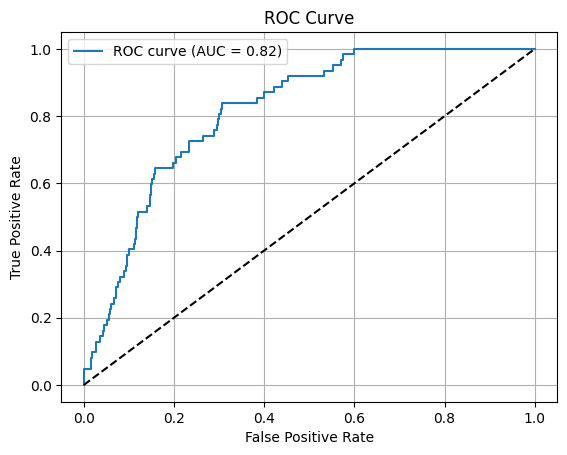

In [45]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # diagonal (random)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1444
           1       0.15      0.70      0.24        89

    accuracy                           0.75      1533
   macro avg       0.56      0.72      0.54      1533
weighted avg       0.93      0.75      0.81      1533



In [48]:
from sklearn.metrics import confusion_matrix


In [49]:
cm = confusion_matrix(y_test, y_pred)


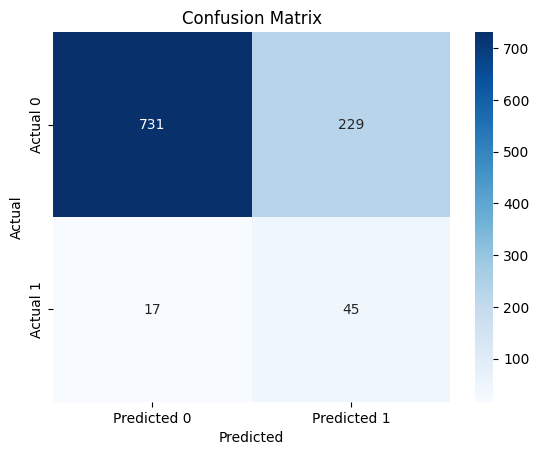

In [ ]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Let’s explore another algorithm that can better handle the issue of imbalanced data.

In [69]:
X_train

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
802,1.0,79.00,0,0,1.0,3.0,0.0,112.64,27.75,1.0
3927,0.0,62.00,0,0,1.0,2.0,1.0,88.32,37.25,0.0
2337,0.0,21.00,0,0,0.0,2.0,0.0,59.52,32.30,2.0
3910,1.0,31.00,0,0,1.0,0.0,1.0,65.70,32.30,1.0
1886,0.0,31.00,0,0,0.0,2.0,0.0,59.63,17.95,2.0
...,...,...,...,...,...,...,...,...,...,...
4426,1.0,43.00,0,0,1.0,0.0,0.0,88.00,32.30,2.0
466,0.0,61.00,1,0,1.0,2.0,0.0,170.05,62.16,3.0
3092,0.0,1.16,0,0,0.0,4.0,1.0,97.28,17.95,0.0
3772,1.0,80.00,0,0,1.0,3.0,0.0,196.08,32.30,1.0


In [72]:
y_train

802     0
3927    0
2337    0
3910    0
1886    0
       ..
4426    0
466     0
3092    0
3772    0
860     0
Name: stroke, Length: 4088, dtype: int64

In [76]:
print((y_train==1).sum())

187


In [51]:
from imblearn.over_sampling import ADASYN

In [ ]:
ada = ADASYN(random_state=42, sampling_strategy='minority')
X_ada_train, y_ada_train = ada.fit_resample(X_train,y_train)

SyntaxError: keyword argument repeated: sampling_strategy (2125212491.py, line 1)

In [78]:
X_ada_train

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1.000000,79.000000,0,0,1.0,3.000000,0.000000,112.640000,27.750000,1.000000
1,0.000000,62.000000,0,0,1.0,2.000000,1.000000,88.320000,37.250000,0.000000
2,0.000000,21.000000,0,0,0.0,2.000000,0.000000,59.520000,32.300000,2.000000
3,1.000000,31.000000,0,0,1.0,0.000000,1.000000,65.700000,32.300000,1.000000
4,0.000000,31.000000,0,0,0.0,2.000000,0.000000,59.630000,17.950000,2.000000
...,...,...,...,...,...,...,...,...,...,...
7759,0.000000,71.846128,0,0,1.0,2.576936,0.576936,193.353534,34.394166,1.423064
7760,0.154841,73.464524,1,0,1.0,2.154841,0.000000,190.794979,35.779007,1.845159
7761,0.356194,69.794255,0,0,1.0,2.000000,0.356194,190.663605,37.250000,2.356194
7762,0.697013,73.000000,1,0,1.0,2.697013,0.697013,193.520513,33.799786,2.000000


In [79]:
print((y_ada_train==1).sum())

3863


In [65]:
pipeline2.fit(X_ada_test,y_ada_test)

Pipeline(steps=[('logreg',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [66]:
y_ada_pred = pipeline2.predict(X_test)

In [67]:
print(classification_report(y_test, y_ada_pred))

              precision    recall  f1-score   support

           0       0.98      0.76      0.85       960
           1       0.16      0.73      0.26        62

    accuracy                           0.75      1022
   macro avg       0.57      0.74      0.56      1022
weighted avg       0.93      0.75      0.82      1022

